# 🔬 Baseline: SVM + HOG per Quality Control

Approccio **tradizionale** di Machine Learning:
- Estrazione feature con **HOG** (Histogram of Oriented Gradients)
- Classificazione con **SVM** (Support Vector Machine)

Tutto usando **sklearn** direttamente, senza wrapper functions.

## 📦 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import pickle

# Sklearn imports
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Computer vision
from skimage.feature import hog
from skimage.io import imread
import cv2

# Plotting
%matplotlib inline
sns.set_style('whitegrid')

print("✅ Imports completati!")

✅ Imports completati!


## 📂 Configurazione Paths

In [2]:
# Paths
DATA_DIR = Path('../data/raw')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Parametri immagini
IMG_SIZE = (64, 64)

print(f"📁 Train dir: {TRAIN_DIR}")
print(f"📁 Test dir: {TEST_DIR}")

📁 Train dir: ..\data\raw\train
📁 Test dir: ..\data\raw\test


## 🖼️ Caricamento Dati

Carichiamo le immagini dalle cartelle `ok/` e `def_front/`

In [3]:
def load_images(data_dir):
    """Carica immagini da directory con sottocartelle ok/ e def_front/"""
    images = []
    labels = []
    
    # Classe 0: OK
    ok_dir = data_dir / 'ok'
    for img_path in ok_dir.glob('*.jpeg'):
        img = imread(str(img_path), as_gray=True)
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
        labels.append(0)
    
    # Classe 1: Defective
    def_dir = data_dir / 'def_front'
    for img_path in def_dir.glob('*.jpeg'):
        img = imread(str(img_path), as_gray=True)
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
        labels.append(1)
    
    return np.array(images), np.array(labels)

# Carica training e test
print("Caricamento training set...")
X_train, y_train = load_images(TRAIN_DIR)
print(f"✅ Train: {len(X_train)} immagini")
print(f"   - OK: {np.sum(y_train == 0)}")
print(f"   - Defective: {np.sum(y_train == 1)}")

print("\nCaricamento test set...")
X_test, y_test = load_images(TEST_DIR)
print(f"✅ Test: {len(X_test)} immagini")
print(f"   - OK: {np.sum(y_test == 0)}")
print(f"   - Defective: {np.sum(y_test == 1)}")

Caricamento training set...
✅ Train: 6633 immagini
   - OK: 2875
   - Defective: 3758

Caricamento test set...
✅ Test: 715 immagini
   - OK: 262
   - Defective: 453


### Visualizza Esempi

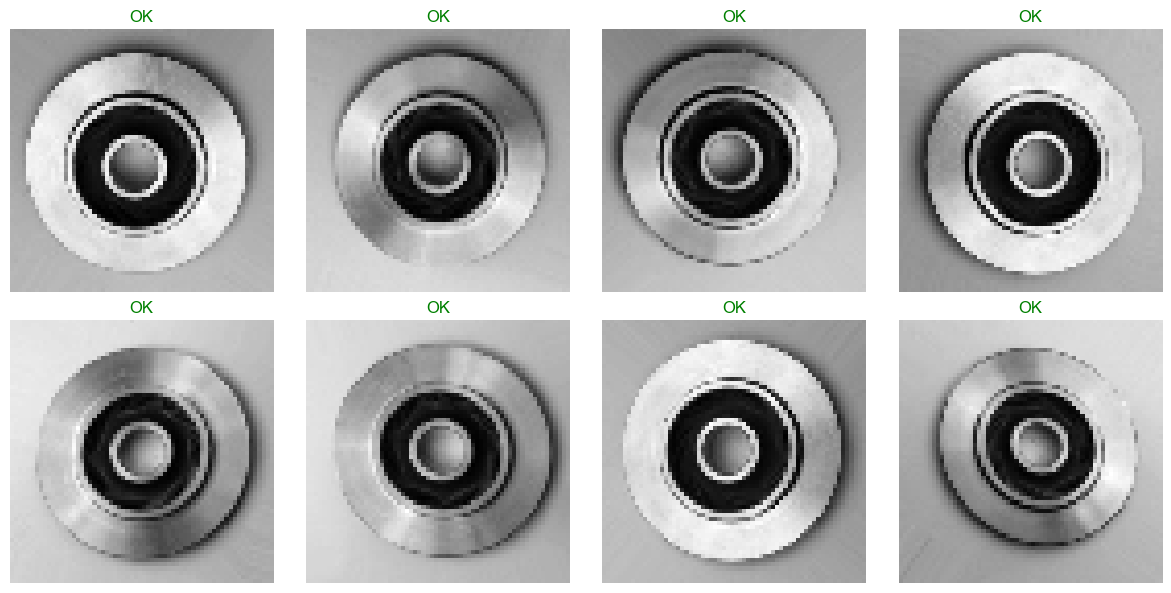

In [4]:
# Plot 8 esempi
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    axes[i].imshow(X_train[i], cmap='gray')
    label = 'OK' if y_train[i] == 0 else 'DEFECTIVE'
    axes[i].set_title(label, color='green' if y_train[i] == 0 else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 🎯 Estrazione Feature HOG

HOG cattura **bordi e forme** nelle immagini

In [5]:
def extract_hog_features(images):
    """Estrae feature HOG da array di immagini"""
    features = []
    
    for img in tqdm(images, desc="Estraendo HOG"):
        # Parametri HOG
        hog_features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            transform_sqrt=True,
            feature_vector=True
        )
        features.append(hog_features)
    
    return np.array(features)

# Estrai feature
print("\nEstrazione HOG dal training set...")
X_train_hog = extract_hog_features(X_train)
print(f"✅ Shape: {X_train_hog.shape}")

print("\nEstrazione HOG dal test set...")
X_test_hog = extract_hog_features(X_test)
print(f"✅ Shape: {X_test_hog.shape}")


Estrazione HOG dal training set...


Estraendo HOG: 100%|██████████| 6633/6633 [00:04<00:00, 1382.47it/s]


✅ Shape: (6633, 1764)

Estrazione HOG dal test set...


Estraendo HOG: 100%|██████████| 715/715 [00:00<00:00, 1380.76it/s]

✅ Shape: (715, 1764)


## 🤖 Training SVM con Grid Search

Troviamo i **migliori hyperparameters** automaticamente

In [6]:
# Parametri da testare
param_grid = {
    'C': [1, 10],           # Regolarizzazione
    'gamma': ['scale'],   # Kernel coefficient
    'kernel': ['rbf']             # Radial basis function
}

# SVM con Grid Search
svm = SVC(random_state=42)
grid_search = GridSearchCV(
    svm, 
    param_grid, 
    cv=3,              # 5-fold cross validation
    n_jobs=1,          # No parallel (evita errori Windows)
    scoring='f1',      # Ottimizza F1 score
    verbose=2
)

print("🚀 Inizio training...\n")
grid_search.fit(X_train_hog, y_train)

print(f"\n✅ Training completato!")
print(f"\n🏆 Migliori parametri:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n📊 Best CV F1 Score: {grid_search.best_score_:.4f}")

🚀 Inizio training...

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   6.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   5.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   5.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   4.1s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   4.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   4.1s

✅ Training completato!

🏆 Migliori parametri:
  C: 10
  gamma: scale
  kernel: rbf

📊 Best CV F1 Score: 0.9815


## 📊 Valutazione su Test Set

In [7]:
# Best model
best_svm = grid_search.best_estimator_

# Predizioni
y_pred = best_svm.predict(X_test_hog)

# Metriche
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📈 Performance su Test Set:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print("\n" + classification_report(y_test, y_pred, target_names=['OK', 'Defective']))

📈 Performance su Test Set:
  Accuracy:  0.9888
  Precision: 0.9955
  Recall:    0.9868
  F1 Score:  0.9911

              precision    recall  f1-score   support

          OK       0.98      0.99      0.98       262
   Defective       1.00      0.99      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



## 🎨 Confusion Matrix

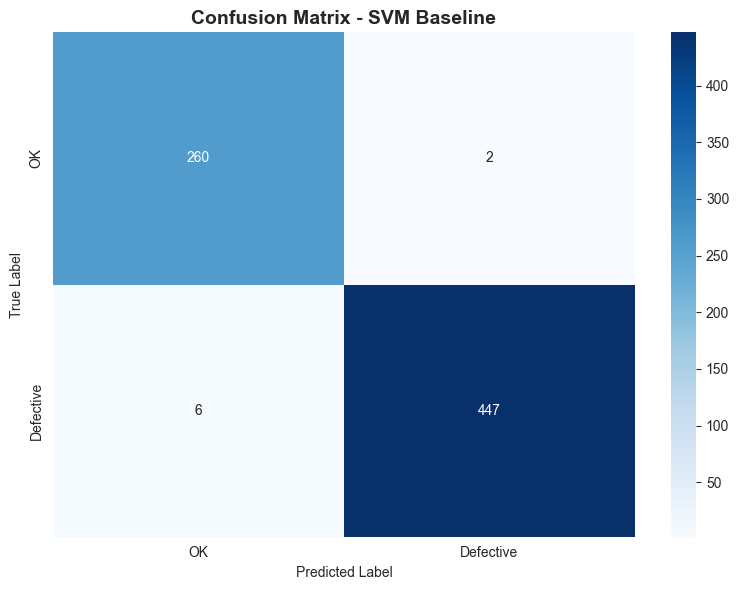

✅ Confusion matrix salvata in: ..\results\svm_confusion_matrix.png


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['OK', 'Defective'],
            yticklabels=['OK', 'Defective'])
plt.title('Confusion Matrix - SVM Baseline', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix salvata in: {RESULTS_DIR / 'svm_confusion_matrix.png'}")

## 💾 Salva Modello

In [9]:
# Salva modello
model_path = RESULTS_DIR / 'svm_withHog_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_svm, f)

print(f"✅ Modello salvato in: {model_path}")

# Salva metriche
results = {
    'accuracy': float(acc),
    'precision': float(prec),
    'recall': float(rec),
    'f1_score': float(f1),
    'best_params': grid_search.best_params_
}

import json
with open(RESULTS_DIR / 'svm_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"✅ Risultati salvati in: {RESULTS_DIR / 'svm_results.json'}")

✅ Modello salvato in: ..\results\svm_withHog_model.pkl
✅ Risultati salvati in: ..\results\svm_results.json


## 🎉 Fine!

Hai trainato un SVM baseline usando:
- ✅ HOG per feature extraction
- ✅ Grid Search per hyperparameter tuning
- ✅ Metriche complete

**Prossimo step**: Apri `02_resnet_training.ipynb` per il deep learning! 🚀